# CSE 578 Final Project

## Team members:
* Rosty Hnatyshyn 
* Kyle Gonzalez 
* Nicholas Seah 
* Sang-Hun Sim 
* Arvind Hasti 
* Chandana Tarur Veerabhadraiah

## Reading the data

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [90]:
# Reading data:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'martial-status', 'occupation', 'relationship', 'race',
                'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                'native-country', 'label']

train_df = pd.read_csv('adult.data',names = column_names,index_col = False, skipinitialspace=True)
test_df = pd.read_csv('adult.test',names = column_names,index_col = False, skiprows = 1, skipinitialspace=True)

## Cleaning the data

In [91]:
# education num is a label encoding, we want to do one-hot so we drop education-num
train_df = train_df.drop('education-num', axis='columns')
test_df = test_df.drop('education-num', axis='columns')

# drop all rows with unknown values
def clear_unknown_rows(df):
    df = df.replace('?',np.NaN)
    # existed in test but not training set, can do this in a better way but skipping for now
    df = df.replace('Holand-Netherlands', np.NaN)
    df = df.dropna()
    return df

train_df = clear_unknown_rows(train_df)
test_df = clear_unknown_rows(test_df)

# make a combined dataframe for later visualizations
combined_df = pd.concat([test_df,train_df])
combined_df.replace({'<=50K.': '<=50K', '>50K.' : '>50K', '<=50K': '<=50K', '>50K' : '>50K'}, inplace=True)

### Cleaning the data: one hot encoding for machine learning

In [92]:
# one hot encoding - added prefix to columns so that we can consolidate them later
def encode_categories(df):
    df = df.join(pd.get_dummies(df.pop('workclass'), prefix='workclass'))
    df = df.join(pd.get_dummies(df.pop('education'), prefix='education'))
    df = df.join(pd.get_dummies(df.pop('martial-status'), prefix='martial-status'))
    df = df.join(pd.get_dummies(df.pop('occupation'), prefix='occupation'))
    df = df.join(pd.get_dummies(df.pop('relationship'), prefix='relationship'))
    df = df.join(pd.get_dummies(df.pop('race'), prefix='race' ))
    df = df.join(pd.get_dummies(df.pop('sex'), prefix='sex'))
    df = df.join(pd.get_dummies(df.pop('native-country'), prefix='native-country'))
    # label needs to be one column instead of two
    # need 4 because there's one with a period and one without
    df.replace({'<=50K.': 0, '>50K.' : 1, '<=50K': 0, '>50K' : 1}, inplace=True)
    return df

numerical_df = train_df.copy()
numerical_df.replace({'<=50K.': 0, '>50K.' : 1, '<=50K': 0, '>50K' : 1}, inplace=True)

train_df = encode_categories(train_df)
test_df = encode_categories(test_df)

In [93]:
# last step is to get the labels from the training set
train_labels_df = train_df['label']
test_labels_df = test_df['label']
train_df = train_df.drop(['label'],axis=1)
test_df = test_df.drop(['label'],axis=1)

## Building the model and running a classification task

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=250,max_depth=8)
clf.fit(train_df,train_labels_df)
y_pred=clf.predict(test_df)

print("Accuracy:", metrics.accuracy_score(test_labels_df,y_pred))

Accuracy: 0.849468791500664


## Retrieving the most important features according to the model

In [95]:
feature_imp = pd.Series(clf.feature_importances_,index=train_df.columns).sort_values(ascending=False)

In [96]:
# importance = clf.feature_importances_
# names = train_df.columns
# model_type = 'Random Forest'
# Importance is feature importance values
# Names is Column names
# model_type is a string describing the model
# topfeatures is the top number features you want to plt
def plot_feature_importance(importance, names, model_type, topfeatures, encoded_categories):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_name': feature_names, 'feature_importance': feature_importance}
        
    FI_df = pd.DataFrame(data)
    for category in encoded_categories:
        this_category = FI_df.loc[FI_df['feature_name'].str.startswith(category)]
        this_category_importance = this_category['feature_importance'].sum(axis=0)
        FI_df = FI_df[~FI_df.feature_name.isin(this_category.feature_name)]
        FI_df = FI_df.append({'feature_name': category, 'feature_importance': this_category_importance}, ignore_index=True)
    
    # Sort DF in terms of feature importance
    FI_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    # Font 
    font = {'fontname': 'Georgia'}
    
    
    
    #Plot Feature Importance Bar Chart
    plt.figure(figsize = (5,5))
    sns.barplot(x = FI_df['feature_importance'][:topfeatures], y = FI_df['feature_name'][:topfeatures])
    # Add chart labels
#     for index, value in enumerate(feature_importance[:topfeatures]):
#         plt.text(value + 0.01, index, str(value), color = 'black', **font)
    
    plt.title(model_type + ' Feature Importance',**font,fontsize = 20,fontweight="bold")
    plt.xlabel('Feature Importance',**font,fontsize = 15,fontweight="bold")
    plt.ylabel('Feature Names',**font,fontsize = 15,fontweight="bold")
    plt.xticks(**font)
    plt.yticks(**font)

## Feature Importance Chart

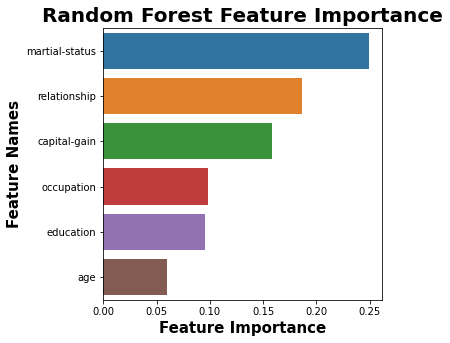

In [97]:
encoded_categories = ('workclass', 'education', 'martial-status', 'occupation', 'relationship',
                      'race', 'sex', 'native-country')
plot_feature_importance(clf.feature_importances_, train_df.columns, 'Random Forest', 6, encoded_categories)

## Martial Status Mosaic Plot

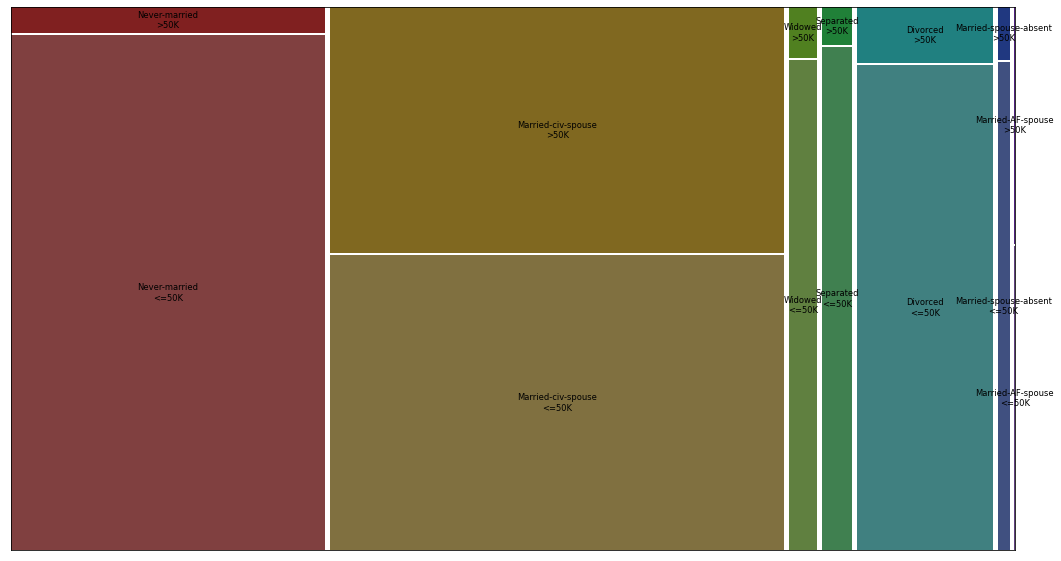

In [108]:
from statsmodels.graphics.mosaicplot import mosaic
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['martial-status', 'label'], ax=axes, axes_label=False)
plt.show()

## Relationship Status Mosaic Plot

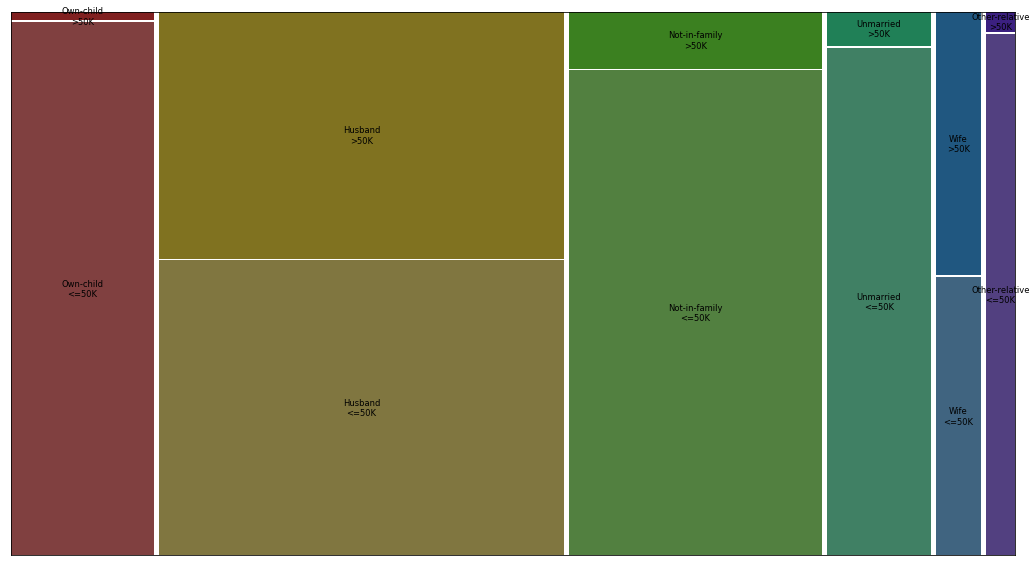

In [99]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['relationship', 'label'], ax=axes, axes_label=False)
plt.show()

## Capital Gain Chart

In [ ]:
#TODO: Need a chart here

## Occupation Mosaic Plot

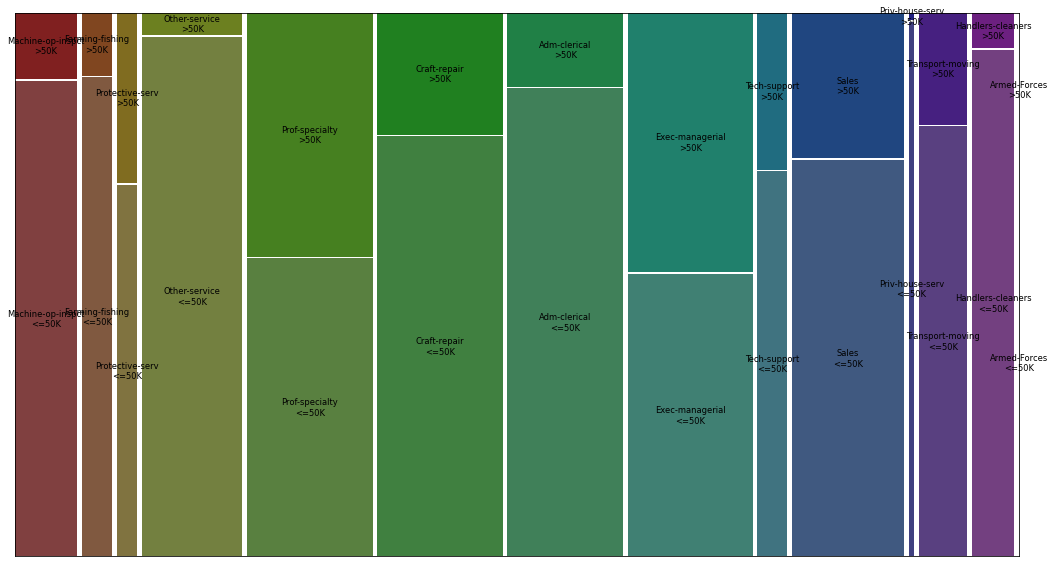

In [102]:
plt.close()
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['occupation', 'label'], ax=axes, axes_label=False)
plt.show()

## Education Mosaic Plot

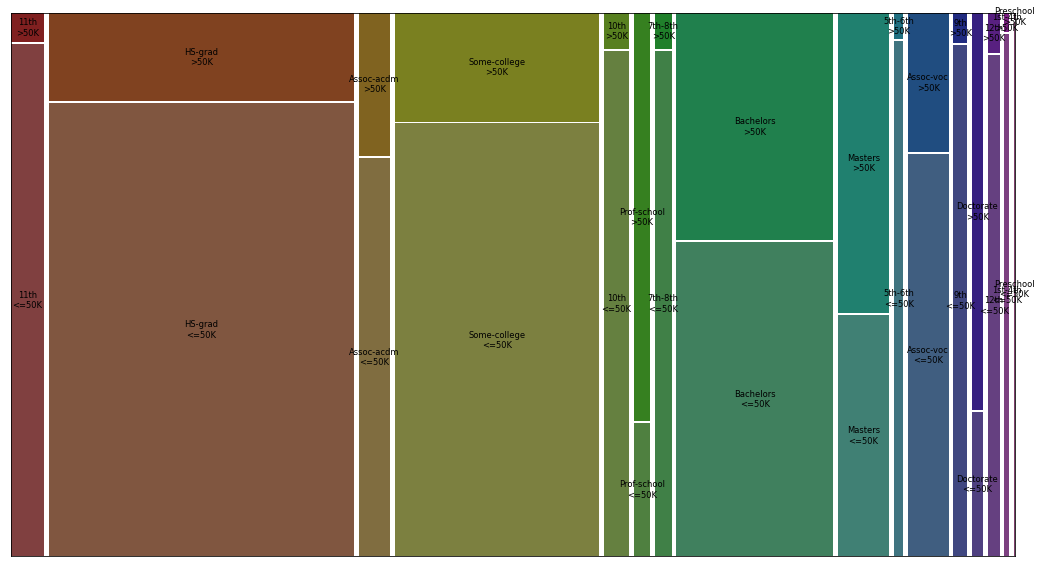

In [105]:
plt.close()
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['education', 'label'], ax=axes, axes_label=False)
plt.show()

## Age Chart

In [106]:
def stacked_bar_f(column):
    x = numerical_df[column]

    x1 = x[numerical_df['label']==1]
    #x2 = x[Age_Label_df['label']==0]

    label1 = ['Total People in' + column + 'Group']
    label2 = ['Percentage with $50K+ Salary']

    plt.figure()
    plt.hist(x , bins = 7 ,rwidth = 0.7 , stacked = True, ec = 'k',label = label1)
    plt.hist(x1 ,bins = 7, rwidth = 0.7, stacked = True, ec = 'k',label = label2)
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title( column +'vs Income')
    plt.legend()
    return plt.show()

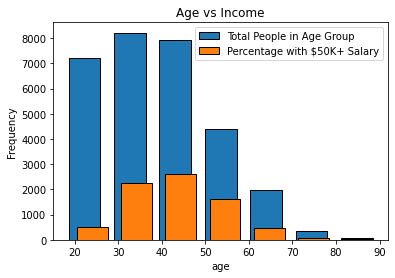

In [107]:
Feature_Series= numerical_df['age']
Label_Series = numerical_df['label']

Age_Label_df = pd.concat([Feature_Series,Label_Series], axis = 1)

x = Age_Label_df['age']

x1 = x[Age_Label_df['label']==1]
x2 = x[Age_Label_df['label']==0]

label1 = ['Total People in Age Group']
label2 = ['Percentage with $50K+ Salary']

plt.figure()
plt.hist(x , bins = 7 ,rwidth = 0.7 , stacked = True, ec = 'k',label = label1)
plt.hist(x1 ,bins = 7, rwidth = 0.7, stacked = True, ec = 'k',label = label2)


plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Age vs Income')
plt.legend()